In [1]:
import numpy as np
import scipy.io
from utils import *
import matplotlib.pyplot as plt
from skimage.restoration import unwrap_phase
import yaml

In [2]:
# %matplotlib inline
# %matplotlib widget

In [3]:
config_name = 'BPRP'
config_path = f'./configs/recon/{config_name}.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Unpack configuration settings
folder = config["folder"]
roi_size_px = config["roi_size_px"]
ROI_length = config["ROI_length"]
recon_alg = config["recon_alg"]
keyword = config["keyword"]
ROI_center = config["ROI_center"]
try:
    use_ROI = config["use_ROI"]
except:
    use_ROI = False
elliptical_pupil = config["elliptical_pupil"]

if 'full' in config_path:
    full_flag = True
    recon_alg = recon_alg + '_full'
else:
    full_flag = False
    

print('Reconstruction algorithm: ', recon_alg)

Reconstruction algorithm:  GN


In [4]:
# effective pixel size
if elliptical_pupil:
    dx_m = 10.8e-9
else:
    dx_m = 15e-9
# effective field size
Dx_m = ROI_length * dx_m
# spatial scales
x_m = np.arange(1, roi_size_px + 1) * dx_m
y_m = np.arange(1, roi_size_px + 1) * dx_m

# wavelength of acquisition
lambda_m = 13.5e-9

# angular frequency scale
fs = 1 / dx_m
Nfft = config["ROI_length"]
df = fs / Nfft
freq_cpm = np.arange(0, fs, df) - (fs - Nfft % 2 * df) / 2
Fx, Fy = np.meshgrid(freq_cpm, freq_cpm)

if elliptical_pupil:
    fc_lens = (np.arcsin(.55/4)/lambda_m)
    a = fc_lens  # semi-major axis
    b = fc_lens / 2  # semi-minor axis
    FILTER = ((Fx/a)**2 + (Fy/b)**2) <= 1

    # # Take 20% obscuration into account
    a_ob = a*0.2
    b_ob = b*0.2
    FILTER[(Fx/a_ob)**2 + (Fy/b_ob)**2 <= 1] = 0
else:
    fc_lens = (np.arcsin(.33/4)/lambda_m)
    a = fc_lens
    b = fc_lens
    FILTER = (Fx**2 + Fy**2) <= fc_lens**2


crop to ROI
max intensity:  7573.0


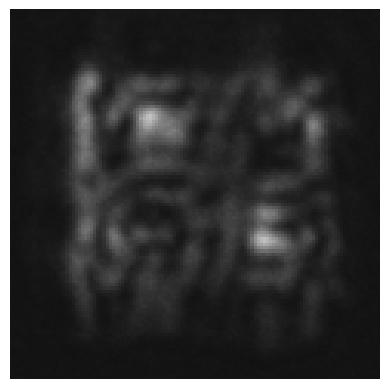

IndexError: index -1 is out of bounds for axis 0 with size 0

In [12]:
# todo: find central measurement as a comparison

path = folder + keyword + '.npz'
data = np.load(path)
img = data['imgs']
img = [img[i,:,:] for i in range(img.shape[0])]
sx = data['sx']
sy = data['sy']


# center crop if using ROI
if (ROI_length < img[0].shape[0]) and use_ROI:
    print('crop to ROI')
    x_m = x_m[ROI_center[0]-int(ROI_length/2):ROI_center[0]+int(ROI_length/2)]
    y_m = y_m[ROI_center[1]-int(ROI_length/2):ROI_center[1]+int(ROI_length/2)]
    img = [i[ROI_center[0]-int(ROI_length/2):ROI_center[0]+int(ROI_length/2), 
             ROI_center[1]-int(ROI_length/2):ROI_center[1]+int(ROI_length/2)] for i in img]


# find the central illumination measurement  with sx = 0 and sy = 0
center_idx = np.where(np.logical_and(sx == 0, sy == 0))[0][0]
center_img = img[center_idx]

# plot 
central_crop = 120
if central_crop is not None:
    top = center_img.shape[0]//2 - central_crop//2
    bottom = center_img.shape[0]//2 + central_crop//2
    left = center_img.shape[1]//2 - central_crop//2
    right = center_img.shape[1]//2 + central_crop//2
    center_img = center_img[top:bottom, left:right]

print('max intensity: ', np.max(center_img))
plt.figure(1)
plt.imshow(center_img, 
        # extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9], 
        cmap='gray', vmin=0, vmax=10000)

# start_pt = int(ROI_length / 2)
# end_pt = int(roi_size_px - ROI_length / 2)
# pts = np.linspace(start_pt, end_pt, 6, dtype=int)
# xx, yy = np.meshgrid(pts, pts) 
# plt.scatter(xx, yy, color='gray', s=10, marker='o')

plt.xlabel('x position (nm)')
plt.ylabel('y position (nm)')
# plt.title('Central illumination measurement')
plt.axis('off')
plt.gca().set_frame_on(False)
plt.show()



print('fov dimensions: ', (x_m[-1]-x_m[0])*1e6, 'um')

    

check the measurement stack to reject those with overlapping bright shadows

In [6]:
# view the meas stack with a slider
from ipywidgets import interact

def view_meas_stack(i):
    plt.figure()
    plt.imshow(img[i], cmap='gray')
    plt.show()

interact(view_meas_stack, i=(0, len(img)-1, 1))

interactive(children=(IntSlider(value=30, description='i', max=61), Output()), _dom_classes=('widget-interact'…

<function __main__.view_meas_stack(i)>

max intensity:  642.0703030399936


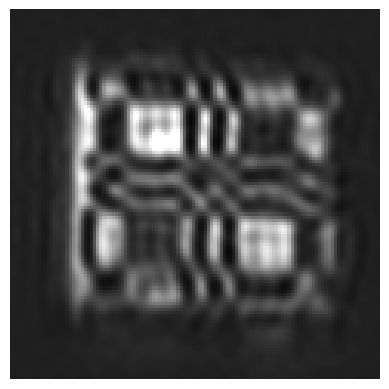

<Figure size 640x480 with 0 Axes>

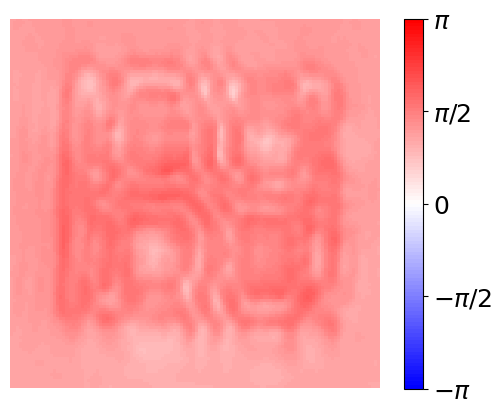

IndexError: index 0 is out of bounds for axis 0 with size 0

In [13]:
def load_recon(folder, recon_alg, downsample=False):
    if recon_alg == 'APIC':
        filename = f'{folder}result/{keyword}_APIC_{str(ROI_length)}.mat'
        recon = scipy.io.loadmat(filename)
        object_guess = recon['himMatching']
        pupil_recon = recon['CTF_abe']
        pupil_recon = np.fliplr(pupil_recon)
        pupil_recon = np.flipud(pupil_recon)
    else:
        recon = scipy.io.loadmat(f'{folder}/result/{config_name}_{recon_alg}_recon.mat')
        object_guess = recon['obj']
        if 'pupil' in recon:
            pupil_recon = recon['pupil']
            full_recon_flag = False
        else:
            pupil_recon = recon['pupil_array']
            full_recon_flag = True
        ideal_FILTER = recon['ideal_FILTER']

    if downsample:        
        if recon_alg == 'GN' or recon_alg == 'APIC':
            downsampled_size = ROI_length
            size_px = object_guess.shape[0]
            object_guess = ft(object_guess)
            object_guess = object_guess[size_px//2-downsampled_size//2:size_px//2+downsampled_size//2, size_px//2-downsampled_size//2:size_px//2+downsampled_size//2]
            object_guess = ift(object_guess)
    
    return object_guess, pupil_recon, ideal_FILTER, full_recon_flag



object_guess, pupil_recon, ideal_FILTER, full_recon_flag = load_recon(folder, recon_alg, downsample=True)


def object_guess_plots(object_guess, central_crop=None):
    if central_crop is not None:
        top = object_guess.shape[0]//2 - central_crop//2
        bottom = object_guess.shape[0]//2 + central_crop//2
        left = object_guess.shape[1]//2 - central_crop//2
        right = object_guess.shape[1]//2 + central_crop//2
        object_plot = object_guess[top:bottom, left:right]
    else:
        object_plot = object_guess
    plt.figure(1)
    plt.imshow(np.abs(object_plot)**2, cmap='gray', vmin=0,vmax=500)
    print('max intensity: ', np.max(np.abs(object_plot)**2))
    # plt.imshow(np.abs(object_guess), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9], cmap='gray')
    # plt.xlabel('x position (nm)')
    # plt.ylabel('y position (nm)')
    # plt.title(f'{recon_alg} reconstruction (amplitude)')
    plt.axis('off')
    plt.show()

    plt.figure(2)
    # Define custom colormap: Blue -> White -> Red
    colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_diverging', colors, N=100)

    fig, ax = plt.subplots()
    # Plot the phase of object_guess
    cax = ax.imshow(
        np.angle(object_plot),
        cmap=cmap, 
        vmin=-np.pi, vmax=np.pi
    )
    ax.set_xlabel('x position (nm)')
    ax.set_ylabel('y position (nm)')
    # ax.set_title(f'{recon_alg} reconstruction (phase)')
    plt.axis('off')
    cbar = fig.colorbar(cax, ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    cbar.ax.set_yticklabels(['$-\pi$', '$-\pi/2$', '$0$', '$\pi/2$', '$\pi$'], fontsize=18)
    plt.show()

    # show a cross section of the intensity and phase
    x_vals = np.linspace(x_m[0]*1e9, x_m[-1]*1e9, object_guess.shape[1])
    plt.figure(3, figsize=(10, 4))
    plt.plot(x_vals, np.abs(object_guess)[ROI_length//2, :])
    plt.xlabel('x position (nm)')
    plt.ylabel('intensity')
    plt.title('Intensity cross section')
    plt.show()

    plt.figure(4, figsize=(10, 4))
    plt.plot(x_vals, np.angle(object_guess)[ROI_length//2, :])
    plt.xlabel('x position (nm)')
    plt.ylabel('phase (rad)')
    plt.title('Phase cross section')
    plt.show()


    # center
    plt.figure(5)
    patch = np.angle(object_guess)[100:200, 500:600]
    # bottom right corner
    # patch = np.abs(object_guess)[10:250, 20:260]
    plt.imshow(patch, cmap='jet')
    plt.axis('off')
    plt.show()


    # show the intensity of the recon spectrum
    plt.figure(6)
    plt.imshow(np.log(np.abs(ft(object_guess)+1)), cmap='gray')
    plt.title('Reconstruction spectrum (amplitude)')
    plt.show()


object_guess_plots(object_guess, central_crop=120)


max intensity:  642.492451511006


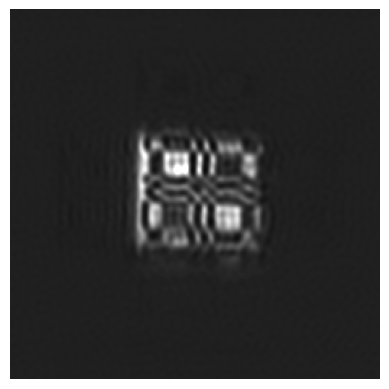

<Figure size 640x480 with 0 Axes>

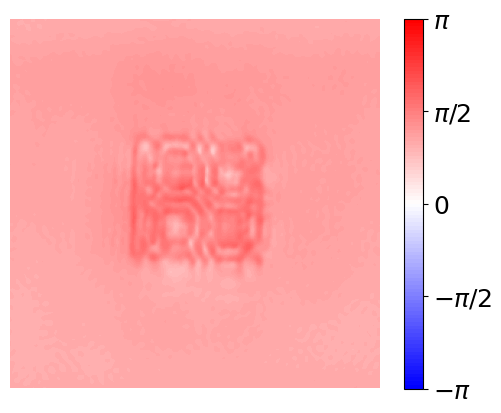

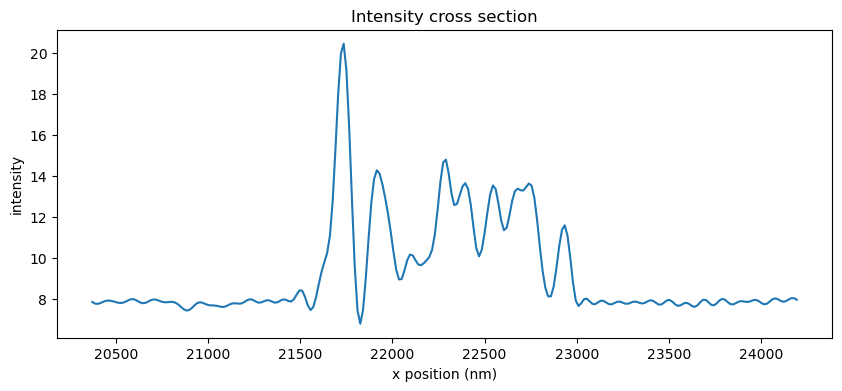

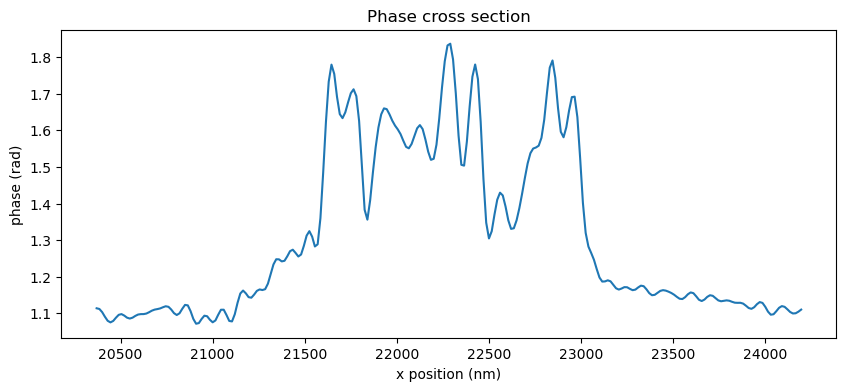

/tmp/ipykernel_3268115/1936098203.py:96: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(patch, cmap='jet')


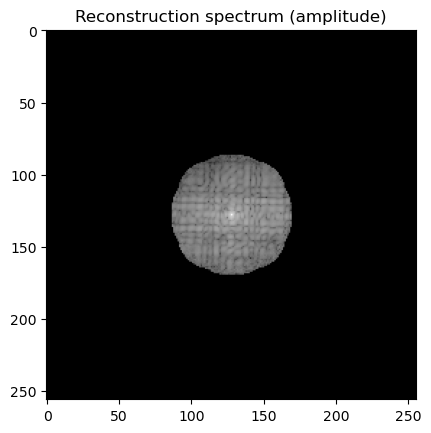

Amplitude loss:  17.961384


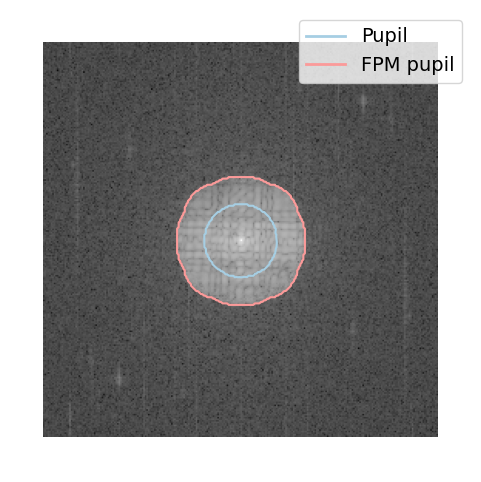

In [8]:
# filter the recon with ideal filter
if full_flag is False:
    recon_filtered = ift(ft(object_guess) * ideal_FILTER)
    object_guess_plots(recon_filtered)
    def FP_forward(spectrum_guess, lens_guess, X, Y, meas):
        pred = np.zeros_like(meas)
        for idx in range(len(X)):
            shifted_spectrum = circshift2(spectrum_guess, X[idx], Y[idx])
            pred[idx] = np.abs(ift(shifted_spectrum * lens_guess))
        return pred

    meas = np.array(img)
    pred = FP_forward(ft(object_guess), pupil_recon, sx, sy, meas)
    amplitude_loss = np.mean((pred - np.sqrt(meas))**2)
    print('Amplitude loss: ', amplitude_loss)
    
    
    from matplotlib.lines import Line2D 
    
    # Compute log spectrum
    log_spectrum = np.log(np.abs(ft(object_guess) + 1))

    # Define colors
    pastel1 = plt.colormaps['Paired']
    pupil_color = pastel1.colors[0]
    ideal_filter_color = pastel1.colors[4]

    # Define zoom region (modify these for desired zoom level)
    central_crop = 300
    zoom_x_min, zoom_x_max = np.size(log_spectrum, 1)//2 - central_crop//2, np.size(log_spectrum, 1)//2 + central_crop//2
    zoom_y_min, zoom_y_max = np.size(log_spectrum, 0)//2 - central_crop//2, np.size(log_spectrum, 0)//2 + central_crop//2

    # Create figure
    plt.figure(figsize=(6, 6))
    plt.imshow(log_spectrum, cmap='gray')

    # Plot contours
    plt.contour(np.abs(pupil_recon), levels=[0.5], colors=[pupil_color])
    plt.contour(np.abs(ideal_FILTER), levels=[0.5], colors=[ideal_filter_color])

    # Set zoomed axis limits
    plt.xlim(zoom_x_min, zoom_x_max)
    plt.ylim(zoom_y_max, zoom_y_min)  # Invert Y-axis to match image coordinates

    # Create legend handles
    legend_elements = [
        Line2D([0], [0], color=pupil_color, lw=2, label='Pupil'),
        Line2D([0], [0], color=ideal_filter_color, lw=2, label='FPM pupil')
    ]

    # Add legend
    plt.legend(handles=legend_elements, loc='upper right', fontsize=14)

    plt.axis('off')
    plt.show()


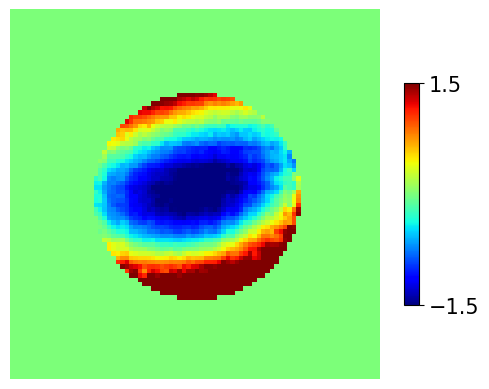

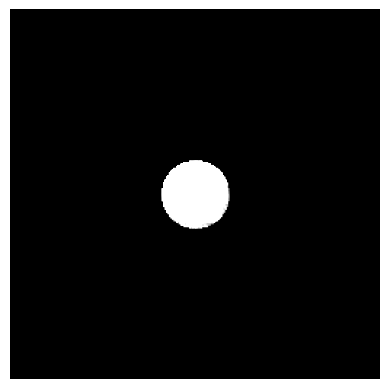

In [9]:
def show_phase(phase):
    
    # Convert to masked array: anything that is NaN becomes masked
    phase = np.ma.masked_invalid(phase)
    
    # Create a custom diverging colormap
    colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # B -> W -> R
    cmap_name = 'custom_diverging'
    cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=100)
    # Force 'bad' (masked) values to display as white
    cm.set_bad('white')

    fig, ax = plt.subplots()
    cax = ax.imshow(phase, cmap='jet', 
                    # vmin=-np.pi/2, vmax=np.pi/2
                    vmin=-1.5, vmax=1.5
                    )
    plt.axis('off')
    
    # Create colorbar
    # cbar = fig.colorbar(cax, ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    # cbar.ax.set_yticklabels(['$-\pi$', '$-\pi/2$', '$0$', '$\pi/2$', '$\pi$']) 
    cbar = fig.colorbar(cax,  ticks=[-1.5, 1.5], shrink=0.6, aspect=15)
    cbar.ax.tick_params(labelsize=15)
    
    plt.show()

# Example usage in your main code
if full_flag is False:
    # crop center region
    size = pupil_recon.shape[0]
    support = size//6
    cropped_pupil_recon = pupil_recon[size//2-support:size//2+support, 
                                      size//2-support:size//2+support]
    phase_unwrapped = unwrap_phase(np.angle(cropped_pupil_recon))
    show_phase(phase_unwrapped)
    
    plt.figure(5)
    plt.imshow(np.abs(pupil_recon), cmap='gray')
    plt.clim(0, 1)
    plt.axis('off')
    plt.show()
    
else:
    n_rows, n_cols, patch_h, patch_w = pupil_recon.shape
    
    # Decide how large each tile should be in the final mosaic
    support = patch_h // 7
    tile_height = 2 * support
    tile_width  = 2 * support
    pupil_map = np.zeros((n_rows * tile_height, n_cols * tile_width))
    

    for i in range(n_rows):
        for j in range(n_cols):
            # Extract the patch from pupil_recon
            patch = pupil_recon[i, j,
                                patch_h//2 - support:patch_h//2 + support,
                                patch_w//2 - support:patch_w//2 + support]
            
            mask = FILTER[patch_h//2 - support:patch_h//2 + support,
                          patch_w//2 - support:patch_w//2 + support]
            patch[~mask] = np.nan
            
            # Place this masked patch into the pupil_map
            row_start = i * tile_height
            row_end   = (i + 1) * tile_height
            col_start = j * tile_width
            col_end   = (j + 1) * tile_width
            pupil_map[row_start:row_end, col_start:col_end] = np.angle(patch)
            

    # Finally, show the resulting tiled phase map with the masked-out region in white
    show_phase(pupil_map)


In [10]:
def sim_illumination(obj, ill, pupil):
    from tqdm.notebook import tqdm

    # note the 4x upsampling in GN recon
    roi_size_px = obj.shape[0]
        
    y_indices, x_indices = np.where(ill == 1)
    pattern_size = ill.shape[0]
    x = np.linspace(-1, 1, pattern_size)
    y = np.linspace(-1, 1, pattern_size)
    x_ill = x[x_indices]
    y_ill = y[y_indices]


    img = np.zeros((roi_size_px, roi_size_px), dtype=np.float32)
    for i in tqdm(range(len(x_ill))):
        x0 = x_ill[i]
        y0 = y_ill[i]
        X0 = round(x0*a*Dx_m)
        Y0 = round(y0*b*Dx_m)
        obj_angle = ift(pupil*circshift2(ft(obj), X0, Y0))
        img_angle = np.abs(obj_angle) ** 2
        img = img + img_angle

    img = img / np.max(img)
    
    return img


def propTF(uin_V_m, lambda_m, z_m):
    M = uin_V_m.shape[0]
    k_1_m = 2*np.pi/lambda_m
    
    #Frequency coordinates
    fx_1_m = np.linspace(-1/(2*dx_m), 1/(2*dx_m) - (1/Dx_m), M)
    fy_1_m = fx_1_m
    FX_1_m, FY_1_m = np.meshgrid(fx_1_m, fy_1_m)
    
    #Transfer function
    H = np.exp(-1j * np.pi * lambda_m * z_m * (FX_1_m**2  + FY_1_m**2))
    H = np.fft.fftshift(H)
    Uin_V_m = np.fft.fft2(np.fft.fftshift(uin_V_m))
    Uout_V_m = H * Uin_V_m
    uout_V_m = np.fft.ifftshift(np.fft.ifft2(Uout_V_m))
    return uout_V_m

        
elliptical_pupil = config["elliptical_pupil"]
lambda_m = 13.5e-9
if elliptical_pupil:
    dx_m = 10.8e-9
else:
    dx_m = 15e-9
Dx_m = ROI_length * dx_m
fs = 1 / dx_m
Nfft = len(x_m)
df = fs / Nfft
freq_cpm = np.arange(0, fs, df) - (fs - Nfft % 2 * df) / 2
Fx, Fy = np.meshgrid(freq_cpm, freq_cpm)
if elliptical_pupil:
    fc_lens = (np.arcsin(.55/4)/lambda_m)
    a = fc_lens
    b = fc_lens / 2
    FILTER = ((Fx/a)**2 + (Fy/b)**2) <= 1
    a_ob = a*0.2
    b_ob = b*0.2
    FILTER[(Fx/a_ob)**2 + (Fy/b_ob)**2 <= 1] = 0
else:
    fc_lens = (np.arcsin(.33/4)/lambda_m)
    a = fc_lens
    b = fc_lens
    FILTER = (Fx**2 + Fy**2) <= fc_lens**2



# Quasar illumination synthesis

  0%|          | 0/1888 [00:00<?, ?it/s]

KeyboardInterrupt: 

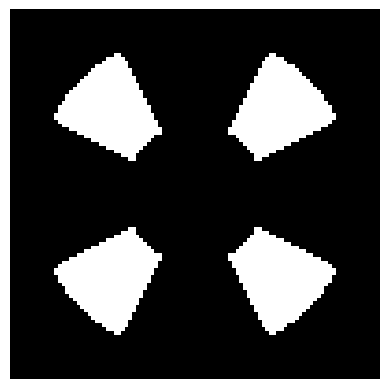

In [11]:
# quasar illumination paramerters
inner_r = 0.38 #0.4
outer_r = 0.88 #0.9
opening_angle = 35
orientation = 45

pattern_size = 100
ill = np.zeros((pattern_size, pattern_size))
x = np.linspace(-1, 1, pattern_size)
y = np.linspace(-1, 1, pattern_size)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)

ring_mask = (R >= inner_r) & (R <= outer_r)


# Convert angles to radians for calculations
angle_offset = np.deg2rad(opening_angle / 2)
orientations = [orientation, orientation + 90, orientation + 180, orientation + 270]
angle_masks = np.zeros_like(ill, dtype=bool)

# Generate masks for the 4 openings
for orientation in orientations:
    angle_rad = np.deg2rad(orientation)
    start_angle = angle_rad - angle_offset
    end_angle = angle_rad + angle_offset
    
    theta = np.arctan2(Y, X)
    theta = np.mod(theta, 2 * np.pi)  # Map angles to [0, 2*pi]
    
    mask = (theta >= start_angle) & (theta <= end_angle)
    mask |= (theta >= start_angle + 2 * np.pi) & (theta <= end_angle + 2 * np.pi)  # Handle wrap-around
    angle_masks = angle_masks | mask

mask = ring_mask & angle_masks
ill[mask] = 1

plt.figure()
plt.imshow(ill, cmap='gray')
plt.axis('off')


img_recon = sim_illumination(object_guess, ill, pupil_recon)

plt.figure()
plt.imshow(img_recon, cmap='gray')
plt.axis('off')

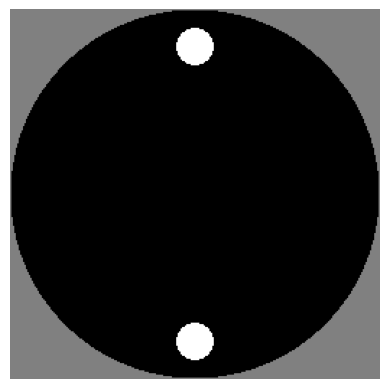

  0%|          | 0/1048 [00:00<?, ?it/s]

(-0.5, 255.5, 255.5, -0.5)

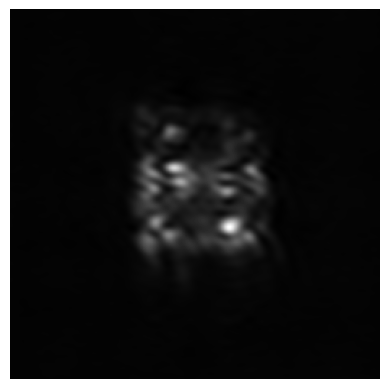

In [12]:
r1 = 0.8
r2 = 0.1

pattern_size = 256
ill = np.zeros((pattern_size, pattern_size))
x = np.linspace(-1, 1, pattern_size)
y = np.linspace(-1, 1, pattern_size)
X, Y = np.meshgrid(x, y)

# Draw to horizontal dipole circles with radius r2 at location r1
mask1 = (X**2 + (Y - r1)**2 <= r2**2)
mask2 = (X**2 + (Y + r1)**2 <= r2**2)

ill[mask1 | mask2] = 1
img = ill
img[np.sqrt(X**2 + Y**2)>1] = 0.5
plt.figure()
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

img_recon = sim_illumination(object_guess, ill, pupil_recon)

plt.figure()
plt.imshow(img_recon, cmap='gray')
plt.axis('off')

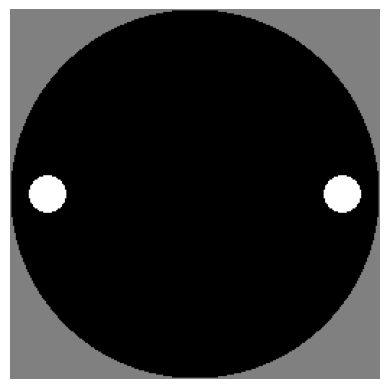

  0%|          | 0/1048 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
r1 = 0.8
r2 = 0.1

pattern_size = 256
ill = np.zeros((pattern_size, pattern_size))
x = np.linspace(-1, 1, pattern_size)
y = np.linspace(-1, 1, pattern_size)
X, Y = np.meshgrid(x, y)

# Draw to horizontal dipole circles with radius r2 at location r1
mask1 = ((X - r1)**2 + Y**2 <= r2**2)
mask2 = ((X + r1)**2 + Y**2 <= r2**2)

ill[mask1 | mask2] = 1
img = ill
img[np.sqrt(X**2 + Y**2)>1] = 0.5
plt.figure()
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

img_recon = sim_illumination(object_guess, ill, pupil_recon)

plt.figure()
plt.imshow(img_recon, cmap='gray')
plt.axis('off')

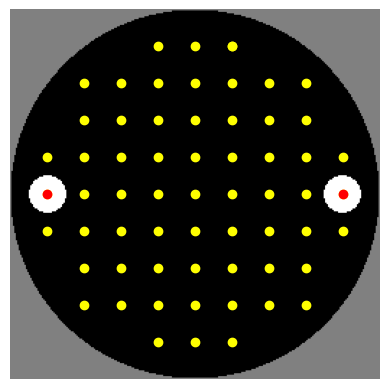

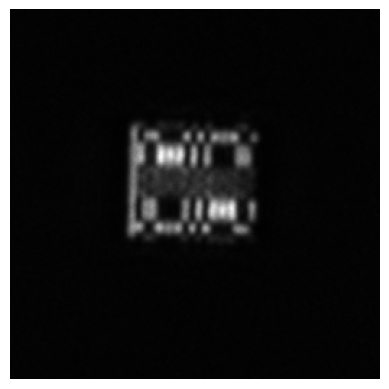

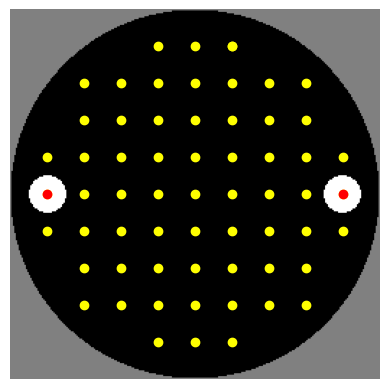

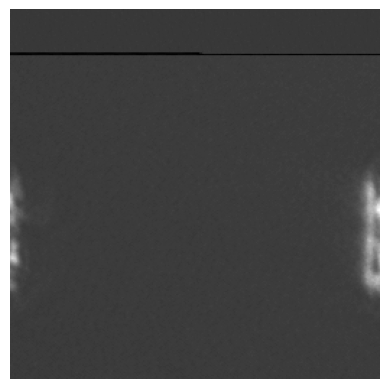

In [14]:
path = folder + keyword + '.npz'
data = np.load(path)
img = data['imgs']
img = [img[i,:,:] for i in range(img.shape[0])]
sx = data['sx']
sy = data['sy']


from scipy.spatial import distance
threshold = 0.1
# Find the true points in the binary mask
true_points = np.column_stack(np.where(ill == 1))
true_points_coords = np.column_stack((x[true_points[:, 1]], y[true_points[:, 0]]))

# Filter points based on the threshold
filtered_points = []
img_sum = np.zeros_like(img[0])
for i, (px, py) in enumerate(zip(sx, sy)):
    distances = distance.cdist([(px, py)], true_points_coords)
    if np.min(distances) < threshold:
        filtered_points.append((px, py))
        img_sum += img[i]

# Extract the filtered points' coordinates
filtered_sx = [p[0] for p in filtered_points]
filtered_sy = [p[1] for p in filtered_points]

plt.figure()
plt.imshow(ill, extent=(-1, 1, -1, 1), origin='lower', cmap='gray')
plt.scatter(sx, sy, color='yellow')
plt.scatter(filtered_sx, filtered_sy, color='red')
plt.axis('off')
plt.show()

raw_size = img_sum.shape[0]
img_direct = img_sum[ROI_center[0]-int(ROI_length/2):ROI_center[0]+int(ROI_length/2), ROI_center[1]-int(ROI_length/2):ROI_center[1]+int(ROI_length/2)]


plt.figure()
plt.imshow(img_direct, cmap='gray')
plt.axis('off')
plt.show()

# Defocus stack simulation

In [15]:
defocus_step_m = 0.01*1e-9*(0.5*1e-3)/(13.5*1e-9)
stack_num = 10
defocus_distances_m = np.arange(stack_num)*defocus_step_m

defocus_images = np.zeros((stack_num, ROI_length, ROI_length))
for i in range(stack_num):
    tmp = propTF(object_guess, lambda_m, defocus_distances_m[i])
    defocus_images[i] = np.abs(tmp)
    # defocus_images[i] = np.abs(ift(ft(tmp)*FILTER))
    
print(defocus_images.shape)
def view_defocus_stack(i):
    plt.figure()
    plt.imshow(defocus_images[i], cmap='gray')
    plt.show()

interact(view_defocus_stack, i=(0, len(defocus_images)-1, 1))

(10, 256, 256)


interactive(children=(IntSlider(value=4, description='i', max=9), Output()), _dom_classes=('widget-interact',)…

<function __main__.view_defocus_stack(i)>

In [16]:
from PIL import Image

# Create a list to hold the frames
frames = []

# Iterate over each frame
for i in range(stack_num):
    fig, ax = plt.subplots()
    ax.imshow(defocus_images[i], cmap='gray')
    
    # Add the text with larger font size using Matplotlib
    ax.text(10, 20, str(i + 1), color='white', fontsize=40, ha='left', va='top')
    
    # Remove axis and border
    ax.axis('off')
    
    # Save the figure as a PIL image in memory
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    # Convert to a PIL image and append to frames
    pil_image = Image.fromarray(frame)
    frames.append(pil_image)
    
    # Close the plot to avoid memory issues
    plt.close(fig)


frames[0].save(f"{folder}/result/{keyword}_defocus_stack.gif", save_all=True, append_images=frames[1:], duration=1000, loop=0)

